In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

import ROOT
import hist

mpl.style.use(hep.style.ATLAS)

Welcome to JupyROOT 6.24/02


## Caratteristiche del sistema che si sta considerando

Abbiamo uno spettrometro con apertura angolare $\alpha = 60^\circ$, calibrato utilizzando alcuni parametri iniziali. 

In [2]:
α = np.pi/3
λ_1 = 579.1e-9 ## [nm] Y
λ_2 = 404.7e-9 ## [nm] P
θ_0 = 1.5701
θ_1 = 2.6958
θ_2 = 2.7904

θ_m3 = 2.6773
θ_m4 = 2.7324
θ_m5 = 2.7651
θ_m6 = 2.7846

Δ_θ = 0.0005
σ_θ = Δ_θ/np.sqrt(3)

Calcolo i parametri A, B dati alcuni valori iniziali, ma devo immaginare che in realtà lo strumento mi viene fornito con una certa caratterizzazione, quindi conidci il valore di A, B (e la loro correlazione? Anche la correlazione con $\theta_0$?)

In [3]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B

Text(1, 0, '')

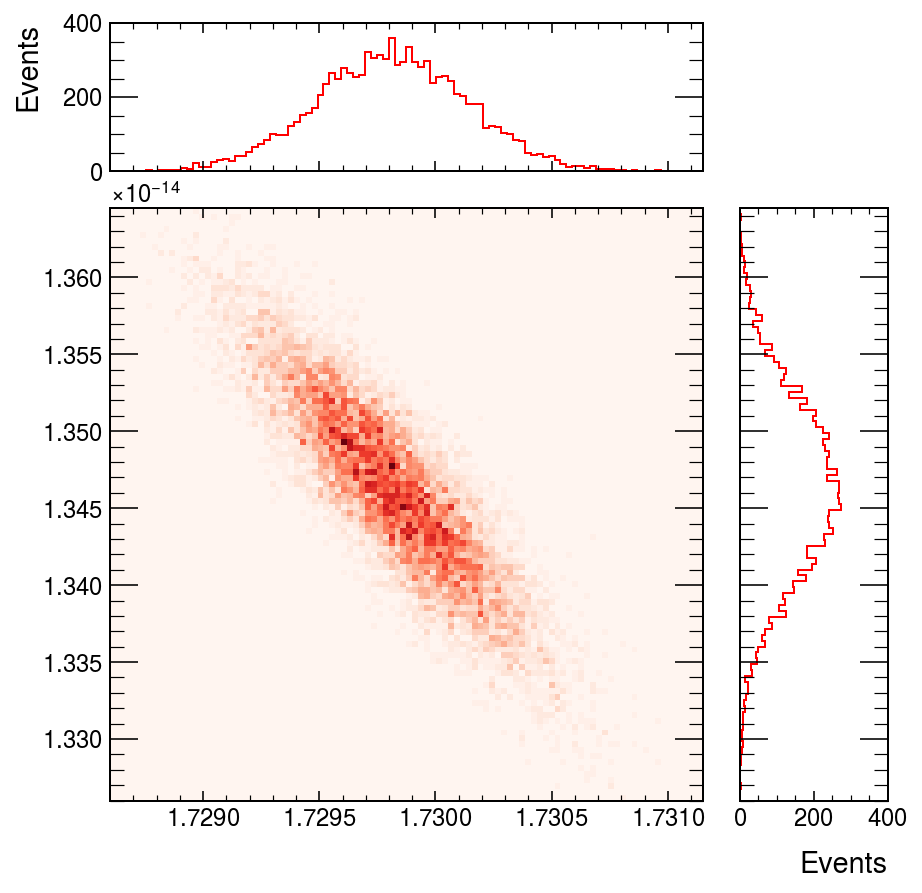

In [16]:
n_samples = 10_000

rnd = ROOT.TRandom3(58347942)

h_AB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

for i in range(n_samples):
    A, B = computeAB(th_0=rnd.Gaus(θ_0,σ_θ), th_1=rnd.Gaus(θ_1,σ_θ), th_2=rnd.Gaus(θ_2,σ_θ))
    h_AB.Fill(A, B)
    
fig = plt.figure(figsize=(6,6))
grid = fig.add_gridspec(2,2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(grid[1,0])
hep.hist2dplot(h_AB, ax=ax, cbar=False, cmap='Reds')

ax_x = fig.add_subplot(grid[0,0], sharex=ax)
ax_y = fig.add_subplot(grid[1,1], sharey=ax)

ax_x.tick_params(axis='x', labelbottom=False)
ax_y.tick_params(axis='y', labelleft=False)

hep.histplot(h_AB.ProjectionX(), yerr=False, ax=ax_x, color='r')
hep.histplot(h_AB.ProjectionY(), yerr=False, ax=ax_y, color='r', orientation='horizontal')

ax_x.set_ylabel('Events')
ax_y.set_xlabel('Events')
ax_x.set_xlabel('')

In [17]:
import uproot
from uncertainties import ufloat

h_λ = h_AB
A = h_λ.ProjectionX().GetMean()
σ_A = h_λ.ProjectionX().GetStdDev()
B = h_λ.ProjectionY().GetMean()
σ_B = h_λ.ProjectionY().GetStdDev()

A_PDF = ufloat(A, σ_A)
B_PDF = ufloat(B, σ_B)

print(f'{A_PDF = :.3uS}, {B_PDF = :.3uS}')

A_PDF = 1.729811(322), B_PDF = 1.34626(580)e-14


In [18]:
def over_λ(θ, θ_0, α, A, B):
    return ( 
        ( 
            np.sin( 
                (θ - θ_0 + α)/2 
            )/np.sin(α/2) - A 
        )/B
    )**0.5

θ = np.array([θ_m3, θ_m4, θ_m5, θ_m6])
one_over_λ_θ_dep = over_λ(θ, θ_0, α, A, B)

In [19]:
m = np.array([3, 4, 5, 6])

<ErrorbarContainer object of 3 artists>

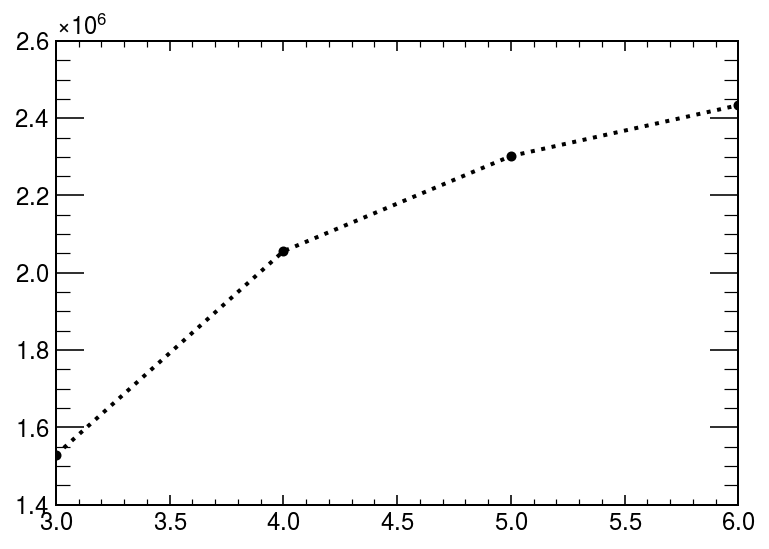

In [20]:
fig, ax = plt.subplots()
ax.errorbar(m, one_over_λ_θ_dep, yerr=np.ones_like(one_over_λ_θ_dep),fmt='k.:')

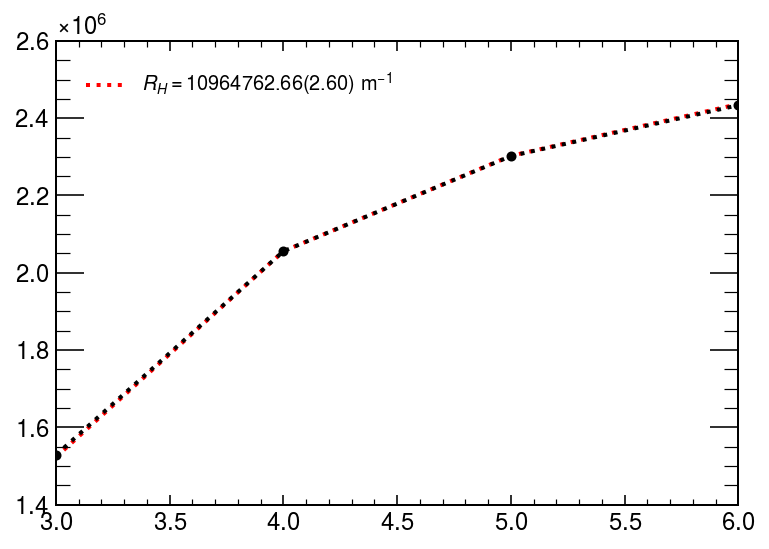

In [21]:
import iminuit 
from iminuit import cost, Minuit

def model(m, R_H):
    return R_H*(0.25-1/m**2)

c = cost.LeastSquares(m,one_over_λ_θ_dep,yerror=np.ones_like(m),model=model)
m1 = Minuit(c, R_H=1)
m1.migrad()

from uncertainties import ufloat

R_H1 = ufloat(m1.values.to_dict()['R_H'], m1.errors.to_dict()['R_H'])

ax.plot(c.x, model(c.x, *m1.values), 'r:', label=f'$R_H = {R_H1:.3uS}$ m$^{{-1}}$')
ax.legend()
fig

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x135005580>, errorbar=None, legend_artist=None)]

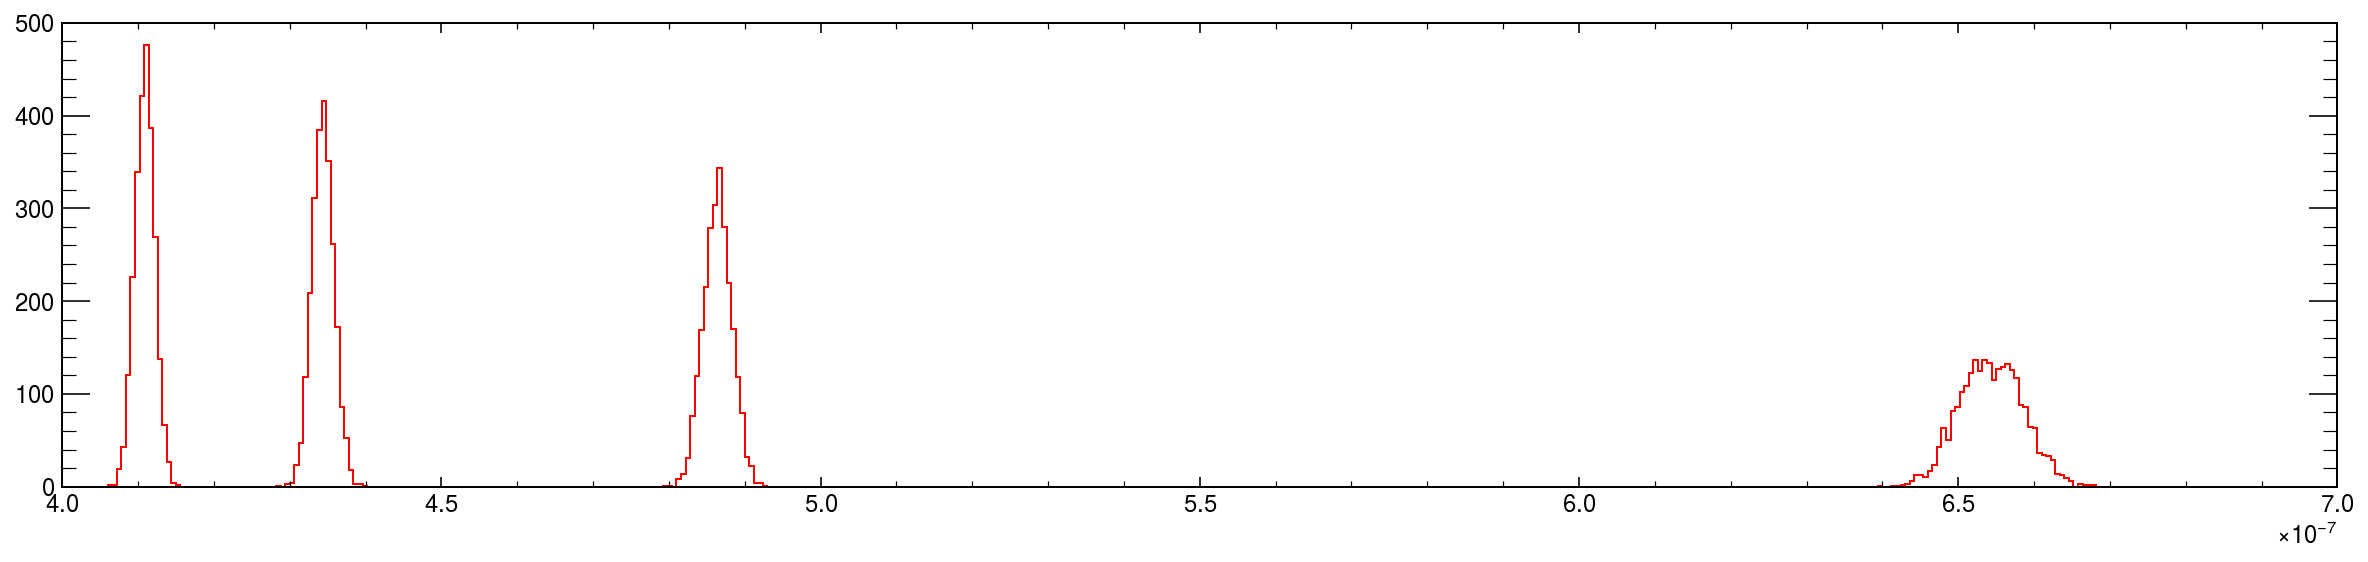

In [22]:
rnd = ROOT.TRandom3(2358972405)

n_samples = 10_000

h_λ = ROOT.TH1D('', '', 500, 400e-9, 700e-9)

for i in range(n_samples):
    binomial = rnd.Rndm()
    if binomial<=0.25 and binomial>=0:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m3, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.5 and binomial>0.25:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m4, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.75 and binomial>0.5:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m5, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    else:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m6, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    
plt.figure(figsize=(20,4))
hep.histplot(h_λ,yerr=False,color='r')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1373e8af0>, cbar=<matplotlib.colorbar.Colorbar object at 0x1373f55b0>, text=[])

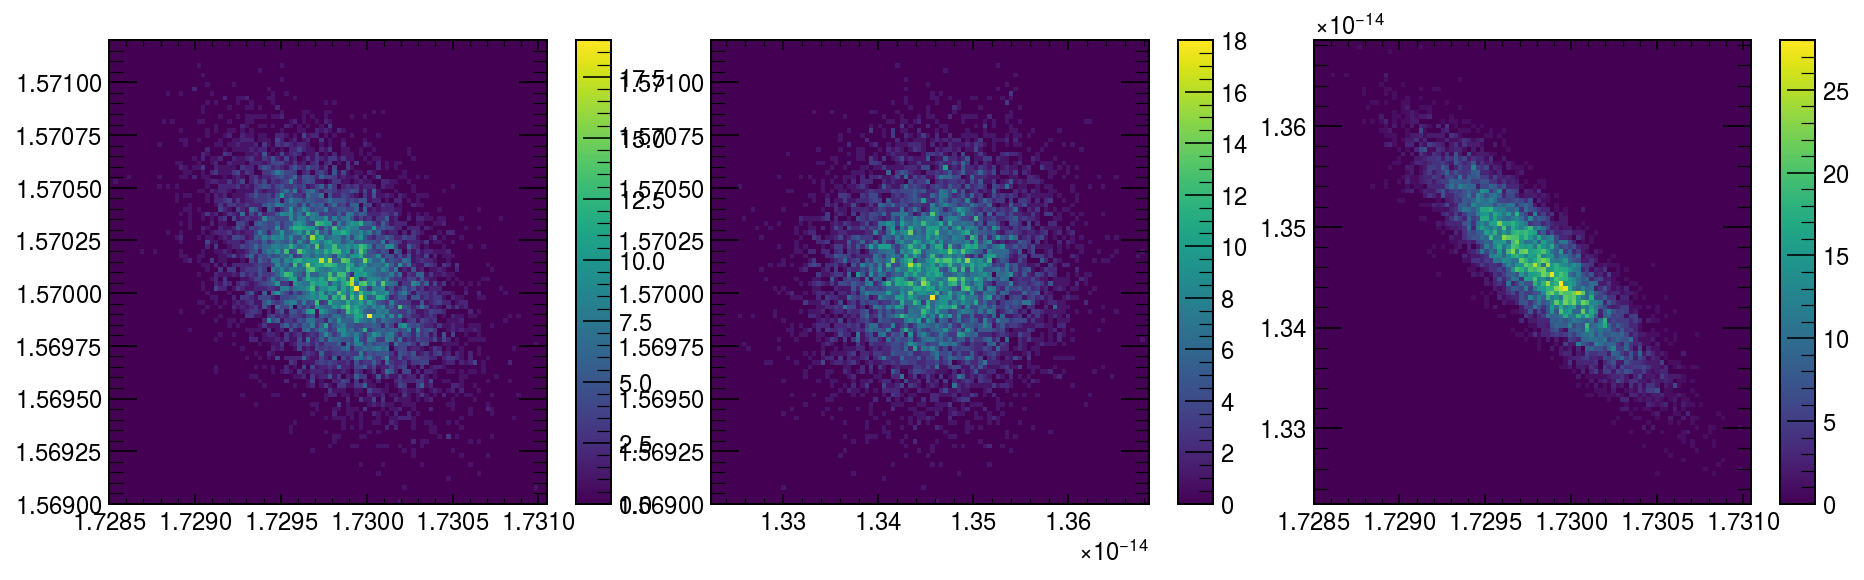

In [26]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B, # n_i(th_1, th_0), n_i(th_2, th_0), th_1-th_0, th_2-th_0

n_samples = 10_000

rnd = ROOT.TRandom3(246357846)

h_Aθ_0 = ROOT.TH2D('', ';A;B', 100, 0, 0, 100,0,0)
h_Bθ_0 = ROOT.TH2D('', ';B;\theta_0', 100, 0, 0, 100,0,0)
h_AB = ROOT.TH2D('', ';A;\theta_0', 100, 0, 0, 100,0,0)

for _ in range(n_samples):
    tmp_θ_0 = rnd.Gaus(θ_0,σ_θ)
    A, B = computeAB(th_0=tmp_θ_0, th_1=rnd.Gaus(θ_1,σ_θ), th_2=rnd.Gaus(θ_2,σ_θ))
    h_Aθ_0.Fill(A,tmp_θ_0)
    h_Bθ_0.Fill(B,tmp_θ_0)
    h_AB.Fill(A,B)

fig, (ax1, ax2, ax3) =plt.subplots(1,3, figsize=(15,4))
hep.hist2dplot(h_Aθ_0,ax=ax1)
hep.hist2dplot(h_Bθ_0,ax=ax2)
hep.hist2dplot(h_AB,ax=ax3)

In [27]:
print(f'Correlation {h_AB.GetCorrelationFactor()   = }')
print(f'Correlation {h_Aθ_0.GetCorrelationFactor() = }')
print(f'Correlation {h_Bθ_0.GetCorrelationFactor() = }')

Correlation h_AB.GetCorrelationFactor()   = -0.8741702361578547
Correlation h_Aθ_0.GetCorrelationFactor() = -0.4427721728941877
Correlation h_Bθ_0.GetCorrelationFactor() = 0.05280748248944365


## Formula per generare due variabili correlate: correlazione tra A e B

Date A, B correlate, avremo che queste due devono essere generate con una dovuta correlazione, corrispondente ad un coeff. $\rho = -0.8735429136694745$. Considerando A generata secondo una distribuzione gaussiana $(A, \sigma_A)$, voglio ottenere il valore di B.